In [1]:
# Import libraries
import sys
import os
import json 
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import h5py
from jupyterlab_h5web import H5Web

In [2]:
from compositionspace.datautils import DataPreparation
from compositionspace.segmentation import CompositionClustering
from compositionspace.postprocessing import DataPostprocess

In [3]:
run = True
if run is True:
    data = DataPreparation("experiment_params.yaml")
    data.get_big_slices()
    data.get_voxels()
    data.calculate_voxel_composition()
    print(f"{data.chunk_files}, {data.voxel_files}, {data.voxel_ratio_file}")

Reading files:   0%|          | 0/5 [00:00<?, ?it/s]

Creating chunks:   0%|          | 0/10 [00:00<?, ?it/s]

Getting Voxels:   0%|          | 0/10 [00:00<?, ?it/s]

Calculating voxel composition:   0%|          | 0/8846 [00:00<?, ?it/s]

['output/file_R31_06365-v02_pos_large_chunks_arr.h5'], ['output/file_R31_06365-v02_pos_small_chunks_arr.h5'], output/output_vox_ratio_composition.h5


## Run the the PCA cumsum

In [4]:
from sklearn.decomposition import PCA
import h5py
import numpy as np

input_file_name = "apm.composition.space.nxs"
h5r = h5py.File(input_file_name, "r")
src = "/entry1/voxelization"
total_weights = h5r[f"{src}/total"][:]
n_ion_types = 73
EPSILON = 1.0e-6  # move to params
composition_matrix = np.zeros([np.shape(total_weights)[0], n_ion_types], np.float64)
for ityp in np.arange(0, n_ion_types):  # make flexible
    ityp_weights = h5r[f"{src}/ion{ityp}/weight"][:]
    if np.shape(ityp_weights) == np.shape(total_weights):
        composition_matrix[:, ityp] = np.divide(ityp_weights, total_weights, where= total_weights >= EPSILON)
        composition_matrix[np.where(composition_matrix[:, ityp] < EPSILON), ityp] = 0.
        composition_matrix[np.isnan(composition_matrix[:, ityp]), ityp] = 0.        
    else:
        raise LogicError("Length of iontype-specific and total weight arrays needs to be the same!")
        break
print(composition_matrix)
h5r.close()

run = True
if run is True:  
    X_train = composition_matrix  # ratios.drop(['Total_no','vox'], axis=1)
    PCAObj = PCA(n_components = n_ion_types)  # len(spec_lst)) 
    PCATrans = PCAObj.fit_transform(X_train)
    PCACumsumArr = np.cumsum(PCAObj.explained_variance_ratio_)

run = False
if run is True:
    plt.figure(figsize=(5,5))
    plt.plot( range(1,len(PCACumsumArr)+1,1),PCACumsumArr,"-o")
    plt.ylabel("Explained Variance")
    plt.xlabel('Dimensions')
    plt.grid()
    output_path = "output"
    output_path = os.path.join(output_path, "PCA_cumsum.png")
    plt.savefig(output_path)
    plt.show()

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [5]:
output_file_name = "apm.composition.space.pca.nxs"
h5w = h5py.File(output_file_name, "w")
trg = "/entry1/composition_clustering_pca"
grp = h5w.create_group(trg)
grp.attrs["NX_class"] = "NXprocess"
dst = h5w.create_dataset(f"{trg}/sequence_index", data=np.uint64(2))
trg = "/entry1/composition_clustering_pca/result"
grp = h5w.create_group(trg)
grp.attrs["NX_class"] = "NXdata"
grp.attrs["axes"] = "axis_pca_dimension"
grp.attrs["axis_pca_dimension"] = np.uint64(0)
grp.attrs["signal"] = "axis_explained_variance"
# further attributes
# to render it a proper NeXus NXdata object
axis_dim = np.asarray(np.linspace(0, n_ion_types - 1, num=n_ion_types, endpoint=True), np.uint32)
dst = h5w.create_dataset(f"{trg}/axis_pca_dimension", compression="gzip", compression_opts=1, data=axis_dim)
dst.attrs["long_name"] = "Dimension"
# dst.attrs["unit"] = ""
axis_expl_var = np.asarray(PCACumsumArr, np.float64)
dst = h5w.create_dataset(f"{trg}/axis_explained_variance", compression="gzip", compression_opts=1, data=axis_expl_var)
dst.attrs["long_name"] = "Explained variance"
# dst.attrs["unit"] = "1"
h5w.close()

In [6]:
H5Web(output_file_name)

<jupyterlab_h5web.widget.H5Web object>

8846
['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19', '20', '21', '22', '23', '24', '25', '26', 'Total_no', 'vox']


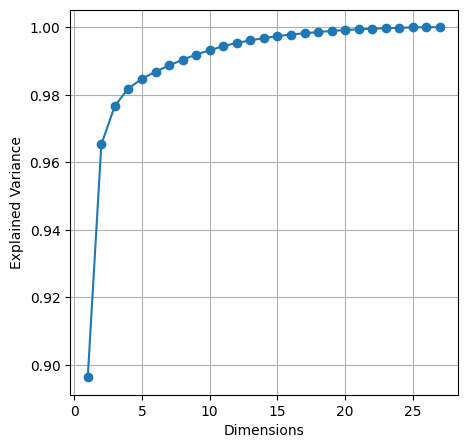

In [7]:
comps = CompositionClustering("experiment_params.yaml")
res = comps.get_PCA_cumsum(data.voxel_ratio_file, data.voxel_files[0])

In [ ]:
with h5py.File(data.voxel_files[0],"r") as hdf:
    group = hdf.get("Group_sm_vox_xyz_Da_spec")
    group0 = hdf.get("0")
    spec_lst = list(list(group0.attrs.values())[1])
    print(f"value {spec_lst}, type {type(spec_lst)}, len {len(spec_lst)}")

Clustering:   0%|          | 0/9 [00:00<?, ?it/s]

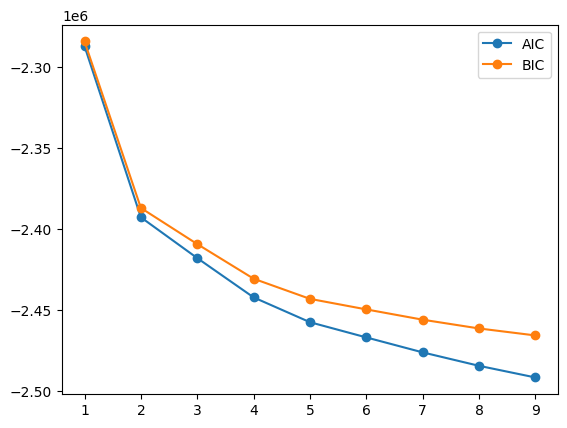

In [8]:
res = comps.get_bics_minimization(data.voxel_ratio_file, data.voxel_files[0])

In [9]:
## Prepare storage of results of BICS minimization via Gaussian mixture

In [14]:
output_file_name = "apm.composition.space.bics.nxs"
h5w = h5py.File(output_file_name, "w")
trg = "/entry1/composition_clustering_ic_opt"  # information criterion optimization (minimization)
grp = h5w.create_group(trg)
grp.attrs["NX_class"] = "NXprocess"
dst = h5w.create_dataset(f"{trg}/sequence_index", data=np.uint64(3))
h5w.close()

## Run the BICS minimization

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


Clustering:   0%|          | 0/5 [00:00<?, ?it/s]

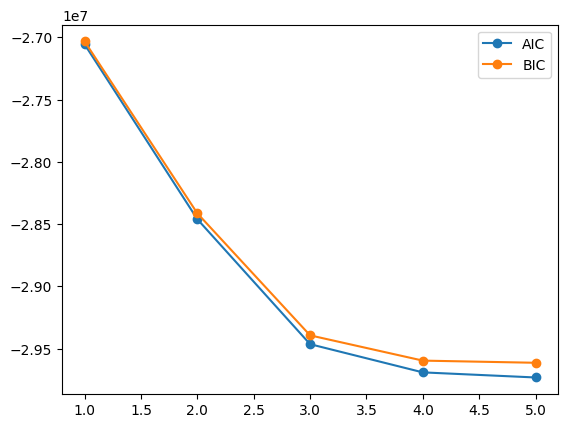

In [15]:
from sklearn.mixture import GaussianMixture
import h5py
import numpy as np
from tqdm.notebook import tqdm

input_file_name = "apm.composition.space.nxs"
h5r = h5py.File(input_file_name, "r")
src = "/entry1/voxelization"
total_weights = h5r[f"{src}/total"][:]
n_ion_types = 73
EPSILON = 1.0e-6  # move to params
composition_matrix = np.zeros([np.shape(total_weights)[0], n_ion_types], np.float64)
for ityp in np.arange(0, n_ion_types):  # make flexible
    ityp_weights = h5r[f"{src}/ion{ityp}/weight"][:]
    if np.shape(ityp_weights) == np.shape(total_weights):
        composition_matrix[:, ityp] = np.divide(ityp_weights, total_weights, where= total_weights >= EPSILON)
        composition_matrix[np.where(composition_matrix[:, ityp] < EPSILON), ityp] = 0.
        composition_matrix[np.isnan(composition_matrix[:, ityp]), ityp] = 0.        
    else:
        raise LogicError("Length of iontype-specific and total weight arrays needs to be the same!")
        break
print(composition_matrix)
h5r.close()

# what are these ?
gm_scores = []
aics = []
bics = []
# y_pred are stored directly into the HDF5 file


h5w = h5py.File(output_file_name, "w")

n_bics_clusters = 5  # 10
n_clusters = list(range(1, n_bics_clusters + 1))  # use instead parameter params bics clusters
# why does the following result look entirely different by orders of magnitude if you change range to np.arange and drop the list creation?
# floating point versus integer numbers, this needs to be checked !!!
# again !!! even though now we are using list and range again the result appear random!!!???
# run sequentially first to assure
pbar = tqdm(n_clusters, desc="Clustering")
for n_cluster in pbar:
    gm = GaussianMixture(n_components=n_cluster, verbose=0)
    gm.fit(X_train)
    y_pred = gm.predict(composition_matrix)
    #gm_scores.append(homogeneity_score(y, y_pred))
    aics.append(gm.aic(composition_matrix))
    bics.append(gm.bic(composition_matrix))
    
    trg = f"/entry1/composition_clustering_ic_opt/cluster_analysis{n_cluster}"
    grp = h5w.create_group(trg)
    grp.attrs["NX_class"] = "NXprocess"
    dst = h5w.create_dataset(f"{trg}/y_pred", compression="gzip", compression_opts=1, data=np.asarray(y_pred, np.uint32))
    # eventually store aics and bics

h5w.close()

output_path = "output"
output_path = os.path.join(output_path, "bics_aics.png")
plt.plot(n_clusters, aics, "-o",label="AIC")
plt.plot(n_clusters, bics, "-o",label="BIC")
plt.legend()
plt.savefig(output_path)
plt.show()
# return self.params["bics_clusters"], aics, bics

In [16]:
output_file_name = "apm.composition.space.bics.nxs"
h5w = h5py.File(output_file_name, "a")
trg = "/entry1/composition_clustering_ic_opt/summary"
grp = h5w.create_group(trg)
grp.attrs["NX_class"] = "NXdata"
grp.attrs["axes"] = "axis_dimension"
grp.attrs["axis_dimension"] = np.uint64(0)
# grp.attrs["signal"] = "axis_aic"  # Akaike information criterion
grp.attrs["signal"] = "axis_bic"  # Bayes information criterion
grp.attrs["auxiliary_signals"] = ["axis_aic"]
dst = h5w.create_dataset(f"{trg}/title", data="Information criterion minimization")

# further attributes
# to render it a proper NeXus NXdata object
axis_dim = np.asarray(np.linspace(1, n_bics_clusters, num=n_bics_clusters, endpoint=True), np.uint32)
dst = h5w.create_dataset(f"{trg}/axis_dimension", compression="gzip", compression_opts=1, data=axis_dim)
dst.attrs["long_name"] = "Number of cluster"
dst.attrs["unit"] = "1"
axis_aic = np.asarray(aics, np.float64)
dst = h5w.create_dataset(f"{trg}/axis_aic", compression="gzip", compression_opts=1, data=axis_aic)
# dst.attrs["long_name"] = "Akaike information criterion"
# dst.attrs["unit"] = ""  # is NX_DIMENSIONLESS
axis_bic = np.asarray(bics, np.float64)
dst = h5w.create_dataset(f"{trg}/axis_bic", compression="gzip", compression_opts=1, data=axis_bic)
dst.attrs["long_name"] = "Information criterion value"  # "Bayes information criterion"
# dst.attrs["unit"] = ""  # is NX_DIMENSIONLESS
h5w.close()

In [17]:
H5Web(output_file_name)

<jupyterlab_h5web.widget.H5Web object>

<div class="alert alert-block alert-danger">
Discussion points:<br>
* Modify NXapm_composition_space<br>
* What to show how to show?<br>
* Number of cluster vs Number of clusters? wording...?<br>
* Why to run the gm several times, ones in the bics loop ones in get composition cluster files 
</div>

In [44]:
comps.get_composition_clusters(data.voxel_ratio_file, data.voxel_files[0])

In [45]:
comps.generate_plots()

In [ ]:
pdata = DataPostprocess("experiment_params.yaml")

In [ ]:
pdata.DBSCAN_clustering(comps.voxel_centroid_output_file, cluster_id = 0,
                        plot=True, plot3d=True, save=True)